In [1]:
!pip install category_encoders

In [2]:
# ==========================
# 1️⃣ إعداد البيئة وتحميل ودمج البيانات (المعدل)
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from category_encoders import TargetEncoder # 💡 المكتبة الجديدة لترميز المدن

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# ⚠️ تحديد مسارات الملفات
FILE_PATH_ORIGINAL = "/kaggle/input/europe-cities-pvgis/europe_cities_pvgis_data_slope_45_azimuth_180.xlsx"
FILE_PATH_NEW = "/kaggle/input/combined-pvgis-data/combined_pvgis_data.xlsx"

try:
    # 1. تحميل البيانات الأصلية
    df_original = pd.read_excel(FILE_PATH_ORIGINAL)
    print(f"Original Data loaded. Shape: {df_original.shape}")
    
    # 2. تحميل البيانات الجديدة
    df_new = pd.read_excel(FILE_PATH_NEW)
    print(f"New Data loaded. Shape: {df_new.shape}")
    
    # 3. الدمج والتنظيف
    # نفترض أن الأعمدة متطابقة، ثم نقوم بالدمج
    df_combined = pd.concat([df_original, df_new], ignore_index=True)
    df_combined = df_combined.dropna()
    
    # تحديث متغير الإطار الذي سيتم العمل عليه لاحقاً
    df = df_combined
    
    print(f"✅ Data Combined successfully. Total Shape after cleaning: {df.shape}")

except FileNotFoundError as e:
    print(f"⚠️ خطأ: لم يتم العثور على أحد ملفات البيانات. يرجى التأكد من اسم المسار/الملف: {e}")
    # إيقاف التنفيذ إذا لم يتم العثور على الملف
    raise

# تحديد العمود الهدف
TARGET_COLUMN = 'G(i)'

Original Data loaded. Shape: (1048575, 13)
New Data loaded. Shape: (1048575, 13)
✅ Data Combined successfully. Total Shape after cleaning: (2097150, 13)


In [3]:
# ==========================
# 2️⃣ معالجة الميزات الزمنية، تنظيف البيانات، وتقسيمها
# ==========================

# 1. تحويل الوقت واستخراج الميزات الدورية (ميزات جيبية)
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d:%H%M')

df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute

# الدوال الجيبية للساعة (دورية 24 ساعة)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# الدوال الجيبية للشهر (دورية 12 شهر)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# 2. حذف الأعمدة الأصلية المُعالَجة وغير المستخدمة
columns_to_drop = [
    TARGET_COLUMN, # سيُفصل لاحقًا
    'Time',        # تم استبداله بالميزات الزمنية
    'Year',        # ليس ميزة مفيدة للتنبؤ الفوري
    'Hour', 'Month', 'Minute', # تم استبدالهم بالدوال الجيبية
    'index' # فهرس مكرر
]

X = df.drop(columns=columns_to_drop, errors='ignore')
y = df[TARGET_COLUMN]

# 3. تحديد أنواع الأعمدة للتحويل
categorical_features = ['City'] # 💡 نركز فقط على City للترميز المستهدف
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 4. إنشاء مُحوِّل (Preprocessor) باستخدام TargetEncoder
preprocessor = ColumnTransformer(
    transformers=[
        # 💡 نستخدم TargetEncoder لـ 'City' لتجنب مشكلة الذاكرة
        ('city_enc', TargetEncoder(min_samples_leaf=20, smoothing=10.0), categorical_features),
        # تطبيق StandardScaler على الأعمدة الرقمية
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# 5. تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1677720, 14)
X_test shape: (419430, 14)


In [4]:
# ===============================================
# 3️⃣ تحسين أداء RandomForest باستخدام Randomized Search & Sampling (المعدل)
# ===============================================

start_time = time.time()

# 1. أخذ عينة أصغر للتحقق المتبادل (لمنع نفاد الذاكرة)
SAMPLE_SIZE = 50000 # 💡 تم زيادة الحجم للاستفادة من البيانات المدمجة
X_train_sample = X_train.sample(n=SAMPLE_SIZE, random_state=42)
y_train_sample = y_train.sample(n=SAMPLE_SIZE, random_state=42)

# 2. إنشاء خط الأنابيب (Pipeline)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 3. تحديد نطاقات المعاملات الفائقة (Hyperparameter Distribution)
rf_param_dist = {
    'regressor__n_estimators': randint(low=50, high=250),
    'regressor__max_depth': randint(low=10, high=30),
    'regressor__min_samples_split': randint(low=2, high=10),
    'regressor__min_samples_leaf': randint(low=1, high=5),
}

# 4. تطبيق البحث العشوائي (RandomizedSearchCV)
rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=25, # 💡 تم زيادة عدد التركيبات العشوائية المراد اختبارها
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42
)

print(f"Starting RandomizedSearchCV for RandomForest on a sample of size: {SAMPLE_SIZE}...")
# التدريب على العينة
rf_random.fit(X_train_sample, y_train_sample) 

end_time = time.time()

print("="*50)
print(f"Random Forest Randomized Search Time: {end_time - start_time:.2f} seconds")
print("Random Forest Best Parameters:", rf_random.best_params_)
print("="*50)

# 5. التنبؤ والتقييم باستخدام أفضل نموذج على مجموعة الاختبار الكاملة
rf_best_estimator = rf_random.best_estimator_
y_pred_rf = rf_best_estimator.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Test Set Metrics:")
print(f"MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

results_df = pd.DataFrame({'Model': ['RandomForest'], 'MAE': [mae_rf], 'RMSE': [rmse_rf], 'R2': [r2_rf]})

Starting RandomizedSearchCV for RandomForest on a sample of size: 50000...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END regressor__max_depth=16, regressor__min_samples_leaf=4, regressor__min_samples_split=6, regressor__n_estimators=64; total time=   2.3s
[CV] END regressor__max_depth=16, regressor__min_samples_leaf=4, regressor__min_samples_split=6, regressor__n_estimators=64; total time=   2.3s
[CV] END regressor__max_depth=16, regressor__min_samples_leaf=4, regressor__min_samples_split=6, regressor__n_estimators=64; total time=   2.3s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   2.6s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   2.5s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   2.6s


In [5]:
# ==========================
# 4️⃣ تدريب وتحسين أداء XGBoost (المعدل)
# ==========================

start_time = time.time()

# 1. إنشاء خط الأنابيب (Pipeline) لـ XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror', 
        n_jobs=-1, 
        random_state=42, 
        n_estimators=100
    ))
])

# 2. تحديد نطاقات المعاملات الفائقة (Hyperparameter Distribution)
xgb_param_dist = {
    'regressor__n_estimators': randint(low=100, high=500),
    'regressor__max_depth': randint(low=3, high=10),
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
}

# 3. تطبيق البحث العشوائي (RandomizedSearchCV) على العينة أيضًا
xgb_random = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=25, # 💡 تم زيادة عدد التركيبات المراد اختبارها
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42
)

# التدريب على العينة (للسرعة)
print(f"\nStarting XGBoost RandomizedSearchCV on a sample of size: {SAMPLE_SIZE}...")
xgb_random.fit(X_train_sample, y_train_sample)

end_time = time.time()

print("="*50)
print(f"XGBoost Randomized Search Time: {end_time - start_time:.2f} seconds")
print("XGBoost Best Parameters:", xgb_random.best_params_)
print("="*50)

# 4. التنبؤ والتقييم
xgb_best_estimator = xgb_random.best_estimator_
y_pred_xgb = xgb_best_estimator.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Test Set Metrics:")
print(f"MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R²: {r2_xgb:.4f}")

# إضافة النتائج للمقارنة
results_df.loc[1] = ['XGBoost', mae_xgb, rmse_xgb, r2_xgb]


Starting XGBoost RandomizedSearchCV on a sample of size: 50000...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END regressor__learning_rate=0.1, regressor__max_depth=6, regressor__n_estimators=448, regressor__subsample=1.0; total time=   1.1s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=6, regressor__n_estimators=448, regressor__subsample=1.0; total time=   1.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=6, regressor__n_estimators=448, regressor__subsample=1.0; total time=   0.9s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=120, regressor__subsample=1.0; total time=   0.4s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=120, regressor__subsample=1.0; total time=   0.4s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=120, regressor__subsample=1.0; total time=   0.4s
[CV] END regressor__learning_rate=0.05, regressor_

Model Performance Summary:
          Model       MAE      RMSE        R2
1       XGBoost  1.913291  4.695153  0.999309
0  RandomForest  2.327782  5.590634  0.999020


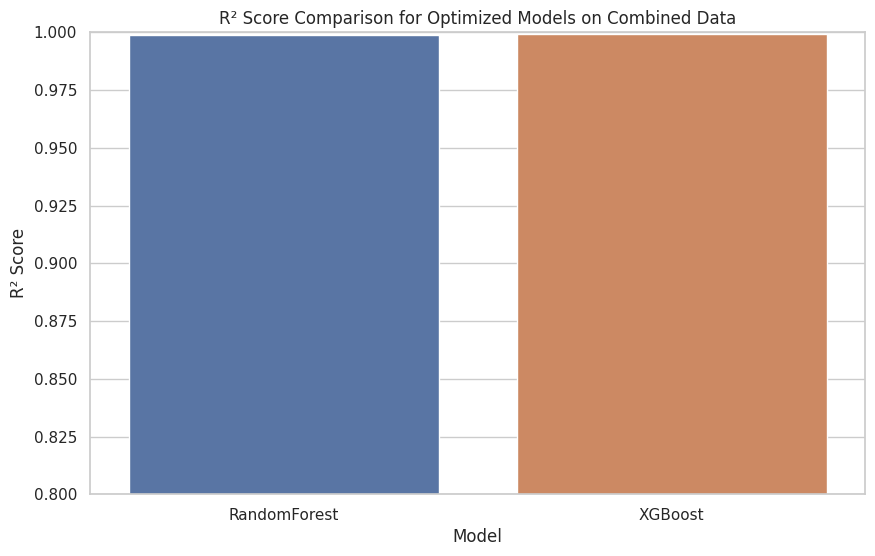

In [6]:
# ==========================
# 5️⃣ مقارنة الأداء والنتائج
# ==========================

print("Model Performance Summary:")
print(results_df.sort_values(by='MAE'))

# الرسم البياني لمقارنة الأداء (R²)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=results_df)
plt.title('R² Score Comparison for Optimized Models on Combined Data')
plt.ylim(0.8, 1.0)
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.show()

⚠️ عدد الميزات (13) لا يطابق عدد القيم المهمة (14).


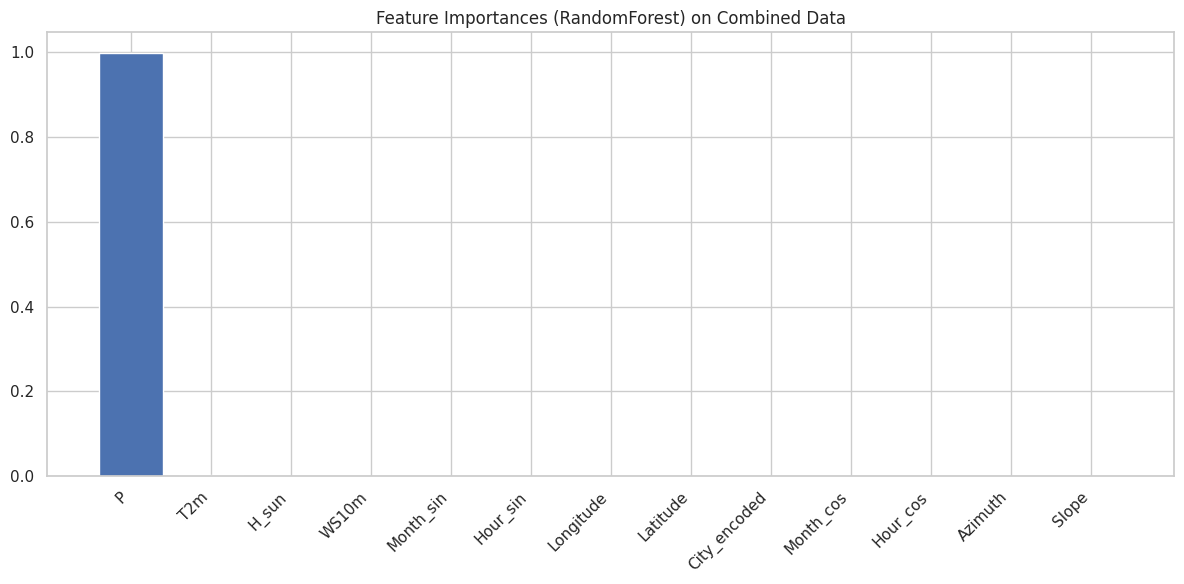

⚠️ عدد الميزات (13) لا يطابق عدد القيم المهمة (14).


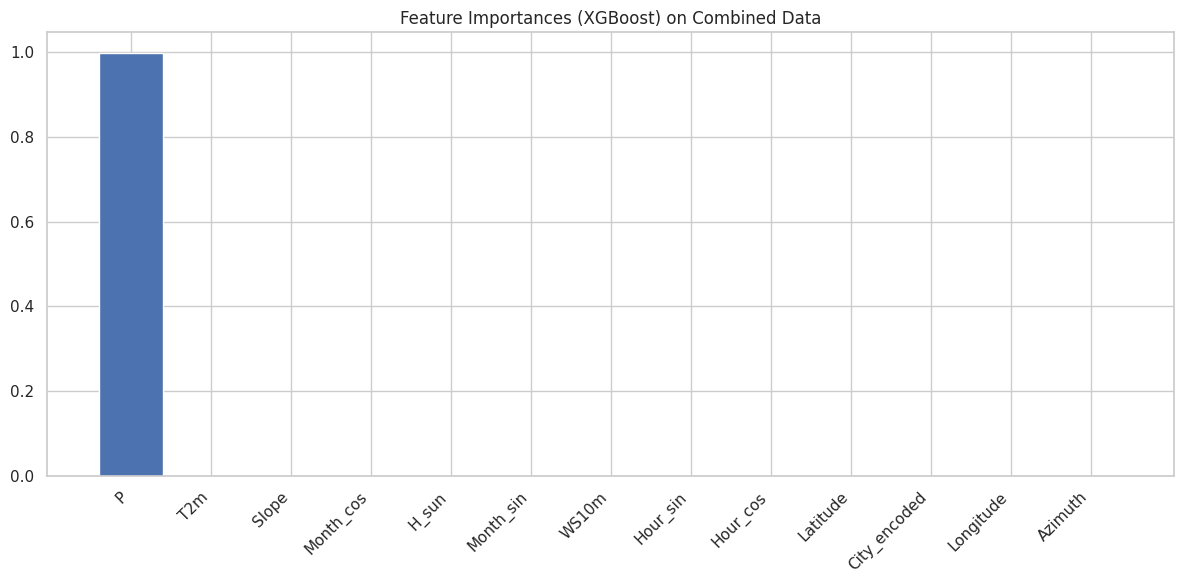

In [7]:
# ==========================
# 6️⃣ رسم أهمية الميزات
# ==========================

def get_feature_names(pipeline):
    """استخراج أسماء الميزات النهائية بعد التحويل."""
    preprocessor = pipeline.named_steps['preprocessor']

    # لو فيه ميزات رقمية
    numerical_names = []
    if 'num' in preprocessor.named_transformers_:
        # نعتمد على القائمة الأصلية للميزات الرقمية بعد StandardScaler
        numerical_names = numerical_features
    
    # لو فيه ميزات فئوية (مثل City)
    categorical_names = []
    if 'city_enc' in preprocessor.named_transformers_: 
        categorical_names = ['City_encoded']

    # دمجهم مع بعض
    full_features = categorical_names + numerical_names
    return full_features


def plot_feature_importance(pipeline, title):
    """رسم أهمية الميزات."""
    features = get_feature_names(pipeline)

    # استخراج الأهمية
    if hasattr(pipeline.named_steps['regressor'], 'feature_importances_'):
        importances = pipeline.named_steps['regressor'].feature_importances_
    else:
        print(f"⚠️ {title} لا يدعم 'feature_importances_'.")
        return

    # التأكد إن الأطوال متساوية
    if len(importances) != len(features):
        print(f"⚠️ عدد الميزات ({len(features)}) لا يطابق عدد القيم المهمة ({len(importances)}).")
        min_len = min(len(importances), len(features))
        importances = importances[:min_len]
        features = features[:min_len]

    # ترتيب الأهمية
    indices = np.argsort(importances)[::-1]
    top_n = min(15, len(features))
    indices = indices[:top_n]

    # رسم النتائج
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances ({title}) on Combined Data")
    plt.bar(range(top_n), importances[indices], align='center')
    plt.xticks(range(top_n), [features[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# تطبيق الدالة
plot_feature_importance(rf_best_estimator, "RandomForest")
plot_feature_importance(xgb_best_estimator, "XGBoost")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


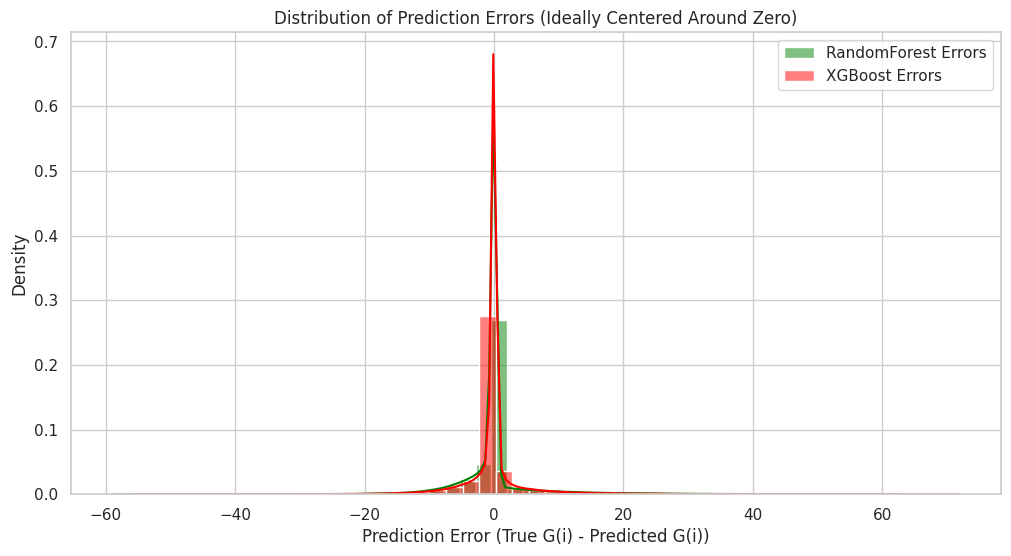

RandomForest Error Statistics:
count    419430.000000
mean         -0.026112
std           5.590580
min         -58.824323
25%          -0.415666
50%           0.000000
75%           0.000000
max          62.853377
Name: G(i), dtype: float64

XGBoost Error Statistics:
count    419430.000000
mean          0.002477
std           4.695158
min         -55.967996
25%          -0.148375
50%          -0.008528
75%           0.019292
max          71.797153
Name: G(i), dtype: float64


In [8]:
# ==========================
# 7️⃣ تحليل توزيع أخطاء التنبؤ
# ==========================

# حساب الأخطاء
rf_errors = y_test - y_pred_rf
xgb_errors = y_test - y_pred_xgb

plt.figure(figsize=(12, 6))

sns.histplot(rf_errors, color='green', label='RandomForest Errors', 
             kde=True, stat="density", bins=50, alpha=0.5)

sns.histplot(xgb_errors, color='red', label='XGBoost Errors', 
             kde=True, stat="density", bins=50, alpha=0.5)

plt.xlabel("Prediction Error (True G(i) - Predicted G(i))")
plt.title("Distribution of Prediction Errors (Ideally Centered Around Zero)")
plt.legend()
plt.show()

# إظهار الإحصائيات الوصفية للأخطاء
print("RandomForest Error Statistics:")
print(rf_errors.describe())
print("\nXGBoost Error Statistics:")
print(xgb_errors.describe())